## Imports

In [12]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from scipy.optimize import minimize
from skimage.exposure import match_histograms
from scipy import signal
from matplotlib import pyplot as plt

## Perameters

In [13]:
kernel_size = (5, 5)
number_of_kernel_elements = kernel_size[0] * kernel_size[1]
initial_kernel_params = np.eye(kernel_size[0], kernel_size[1]).flatten()

## Helper Functions

In [14]:
def process_image(img, kernel_params, kernel_size = (3, 3)):
    # Reshape 9-element kernel_params into a 3x3 matrix
    kernel = np.array(kernel_params).reshape(kernel_size)
    
    # Apply convolution
    processed = cv2.filter2D(img, -1, kernel)
    
    return processed

In [15]:
def objective_function(kernel_params, img, target, kernel_size=(5, 5), alpha=0.01):
    kernel = np.array(kernel_params).reshape(kernel_size)
    processed = cv2.filter2D(img, -1, kernel)
    
    mse = np.mean((processed - target) ** 2)
    ssim_value = ssim(processed, target)
    
    # Combine MSE and SSIM, and add L2 regularization
    objective = mse - ssim_value + alpha * np.sum(kernel ** 2)
    
    return objective

In [16]:
def show_image(img, cmap = "gray"):
    %matplotlib inline
    plt.imshow(img, cmap)
    plt.show()

In [17]:
def save_img_arr(imgs, fname = "img array"):
    widths, heights = zip(*(i.size for i in imgs))
    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in imgs:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im.save('test.jpg')

## Algo

In [18]:
# Load images
img = cv2.imread('Prostate.jpg', cv2.IMREAD_GRAYSCALE)
target = cv2.imread('good.jpg', cv2.IMREAD_GRAYSCALE)

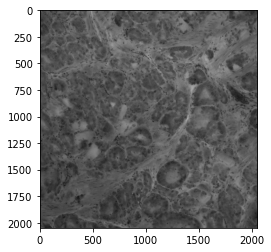

In [19]:
show_image(img, cmap="gray")

In [20]:
# Bounds for kernel parameter optimization (adjust as needed)
kernel_bounds = [(0, 1)] * number_of_kernel_elements

# Optimization using a different method (e.g., SLSQP)

result = minimize(objective_function, initial_kernel_params, args=(img, target, kernel_size),
                  method='L-BFGS-B', options={'maxiter': 100})

In [ ]:
optimal_kernel_params = result.x
print("Optimal kernel parameters:")
print(optimal_kernel_params)

# Reshape optimal parameters into a 3x3 kernel matrix
optimal_kernel_matrix = optimal_kernel_params.reshape(kernel_size)

# Process input image with optimal kernel
final_image = process_image(img, optimal_kernel_params)

# Histogram matching
final_image = match_histograms(final_image, target)

# Ensure the image is in the correct range
final_image = np.clip(final_image, 0, 255).astype(np.uint8)

Optimal kernel parameters:
[0.02116565 0.26783906 0.01123574 0.62854063 0.17632378 0.25975328
 0.03130655 0.61581472 0.64986946]


In [ ]:
result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.42135204126980785
       x: [ 2.117e-02  2.678e-01  1.124e-02  6.285e-01  1.763e-01
            2.598e-01  3.131e-02  6.158e-01  6.499e-01]
     nit: 1
     jac: [ 0.000e+00  0.000e+00 -6.450e-01  0.000e+00 -1.172e+00
            0.000e+00  3.016e-01  0.000e+00  6.717e+00]
    nfev: 21
    njev: 1

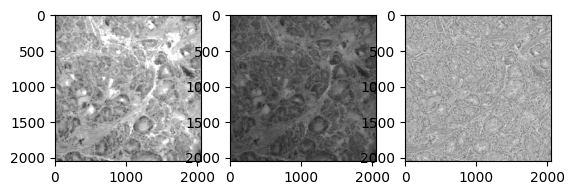

In [ ]:
height, width = final_image.shape

# Create a blank canvas that can hold all three images side by side
combined_image = np.zeros((height, width * 3), dtype=final_image.dtype)

# Place each image onto the canvas
combined_image[:, :width] = final_image
combined_image[:, width*2:] = img
combined_image[:, width:width*2] = target

# Save the combined image
cv2.imwrite('combined_image.png', combined_image)

# Display the images using matplotlib
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(final_image, cmap="gray")
axarr[1].imshow(img, cmap="gray")
axarr[2].imshow(target, cmap="gray")
plt.show()


In [ ]:
x = [ [2.117e-02, 2.678e-01,  1.124e-02],   [6.285e-01,  1.763e-01,
            2.598e-01,],   [3.131e-02,  6.158e-01,  6.499e-01]]
plt.imsave("output.png", signal.convolve2d(img, x), cmap="gray")

In [ ]:
3-4 gausian functions and optimize those instead